# Scipyで２次計画問題を解く〜ポートフォリオ最適化の例〜

２次計画問題はScipyのオプティマイザーのメソッド'SLSQP'で解くことができます．

今回は，ポートフォリオ最適化を例にして，Scipyで２次計画問題を実装してみます．

https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.optimize.minimize.html

## 準備

はじめに今回用いるライブラリをインポートしておきます．

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
%matplotlib inline

今回の例では，Kenneth R. French教授のData Libraryの30業種ポートフォリオのデータを用います．

http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [2]:
name = '30_Industry_Portfolios'
df_dict = pdr.DataReader(name=name, data_source='famafrench')
df = df_dict[0]
df.head(10)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2010-01,-0.92,-3.70,-3.15,1.12,1.23,0.85,-3.11,0.00,-4.04,-8.66,...,-6.84,-7.10,-7.88,-5.49,-4.04,-2.55,-1.92,-0.98,-1.18,2.24
2010-02,2.92,0.25,5.00,6.02,-1.78,3.69,6.07,0.37,5.46,15.68,...,2.92,2.84,6.30,3.05,7.25,5.89,4.32,4.50,2.71,1.87
2010-03,4.44,6.11,6.36,12.06,5.53,2.13,11.39,3.61,7.34,8.42,...,7.88,5.22,8.13,5.86,8.11,5.99,6.14,8.27,8.14,9.07
2010-04,-1.46,-1.76,-3.03,10.96,2.32,1.21,4.23,-2.22,3.08,11.43,...,3.82,0.46,3.89,4.21,3.82,3.20,1.85,7.31,0.95,3.86
2010-05,-5.37,-3.88,-7.71,-7.05,-10.12,-4.35,-5.67,-8.01,-9.99,-9.87,...,-5.91,-8.31,-7.07,-8.89,-5.98,-4.01,-5.83,-4.76,-9.12,-10.05
2010-06,-1.97,-1.63,3.54,-8.80,-8.70,-3.24,-9.31,-1.63,-7.79,-14.55,...,-4.33,-6.78,-5.99,-2.30,-7.66,-5.20,-10.56,-5.21,-7.31,-7.58
2010-07,5.04,8.37,11.12,7.85,5.29,4.22,8.34,2.15,14.24,6.81,...,9.74,8.23,6.82,7.64,10.84,3.20,4.65,6.90,6.62,8.03
2010-08,-0.46,-0.01,-0.05,-1.32,-10.04,-3.96,-7.41,-1.66,-0.11,-5.50,...,-2.23,-5.26,-8.21,-6.06,-4.65,-7.55,-4.18,0.46,-8.38,-7.12
2010-09,1.57,4.95,10.04,14.16,12.91,3.98,17.54,9.00,9.96,13.39,...,7.87,11.62,13.48,9.16,9.87,9.90,13.59,7.06,7.46,10.01


### 期待リターン(収益率)を計算する

<img src="port_return.png">

In [3]:
mean = df.mean()

平均は１次元の形式（pandas.Seriesや１次元のnumpy.ndarray）にしておきます．

### リスクを計算する

<img src="port_risk.png">

In [4]:
cov = df.cov()
std = np.sqrt(np.diag(cov))

### プロットする

各資産を標準偏差と期待リターンでプロットし，シャープレシオ(リスクフリーレートは考慮しない)で色付けします．

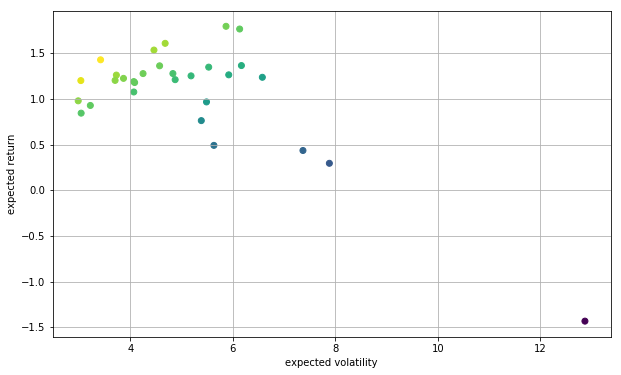

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(std, mean, c=mean/std, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')

これらの資産への最適な投資比率を決定するのが目的です．

## SciPy Optimization で二次計画問題を解く

### H.M.Markowitzの平均・分散モデル

H.M.Markowitz(1952)は“Portfolio Selection”で，ポートフォリオの期待リターンが目標リターン以上になるという制約条件のもと，ポートフォリオの分散を最小化する平均・分散モデルを提案しています．

<img src=port_qp.png>

### scipy.optimize.minimize() を使う

In [6]:
import scipy.optimize as sco

scipy.optimize.minimize()の主な引数は以下のものがあります．



|parameters|内容|type|
|:--|:--|:--|
|fun|目的関数|関数|
|x0|初期解|ndarray などシーケンス|
|method|ソルバー|'SLSQP':逐次最小二乗法|
|bounds|上下限制約|tupleのシーケンス|
|constraints|制約条件|dict または dictのシーケンス|


一つずつ説明していきます．

### 目的関数：最小化する関数を定義する

平均・分散モデルではポートフォリオの分散を目的関数とします．
投資比率を引数として，以下の関数を定義します．

In [7]:
def min_func_var(weights):
    return np.dot(weights.T, np.dot(cov, weights))

### 初期解

初期解を設定します．今回は資産数$n$とし，各資産への投資比率が$\frac{1}{n}$となるように資産数分の初期解をリストとして生成します．

In [8]:
x0 = [1. / len(mean)] * len(mean)

### 目標リターン：自分で決める

目標リターンを設定します．
目標リターンは，投資家が恣意的に決めますが，今回は個々の資産の期待リターンの水準を参考に決めます．

In [9]:
tret = mean.mean()  # e.g.: tret = 0.5

### 制約条件

制約条件は等式制約と不等式制約があります．：
- 'type'に'eq'を指定すると等式制約で，'fun'に左辺=0となる関数を定義します．
- 'type'に'ineq'を指定すると不等式制約で，'fun'は左辺>=0となる関数を定義します
<br>

平均・分散モデルでは等式制約として投資比率の和が１となる制約，不等式制約としてポートフォリオのリターンが目標リターン以上となる制約を加えます．

In [10]:
cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, 
        {'type': 'ineq', 'fun': lambda x: np.sum(mean * x) - tret}]

### 上下限制約

上下限制約：各決定変数の(最小，最大)の組を決定変数の数分並べたシーケンスとして定義します．

通常，空売り禁止制約として下限０を設定します．

In [11]:
bnds = [(0, None)] * len(mean)

### 最適化

最適化を実行します．

In [12]:
%%time
opts = sco.minimize(fun=min_func_var, x0=x0, method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 64.7 ms, sys: 1.99 ms, total: 66.7 ms
Wall time: 65.8 ms


In [13]:
opts

     fun: 6.4382200570155153
     jac: array([ 12.86967444,  12.88338792,  17.07558435,  16.22200376,
        16.85564399,  12.86223888,  12.91390479,  12.88969362,
        17.00302589,  18.76555657,  17.04112363,  18.64207184,
        17.00152731,  16.5060941 ,  16.78500116,  14.17968714,
        13.70201218,  16.07571757,  14.00374794,  12.86757839,
        14.81756985,  14.18152452,  15.26657546,  16.06373262,
        14.38778698,  13.2118395 ,  13.79812872,  12.89780128,
        13.23550874,  13.95237762,   0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 293
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([  8.09082690e-02,   1.81076080e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.23625879e-01,
         5.29605656e-14,   4.31335643e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.87447714e-14,   6.68065863e-1

最適解と最適値をそれぞれ取り出します．

|Returns|内容|
|:--|:--|
|x|最適解|
|fun|最適値|
|success|最適化に成功したか|


In [14]:
opts['x']

array([  8.09082690e-02,   1.81076080e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.23625879e-01,
         5.29605656e-14,   4.31335643e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.87447714e-14,   6.68065863e-14,   4.68453401e-14,
         3.45044089e-14,   2.70424480e-01,   0.00000000e+00,
         1.36019668e-14,   0.00000000e+00,   0.00000000e+00,
         1.52070197e-14,   4.56967363e-14,   1.35369146e-14,
         2.00831727e-01,   5.60252799e-14,   1.37926779e-14])

In [15]:
opts['fun']

6.4382200570155153

In [16]:
opts['success']

True

### 効率的フロンティアを描く

<img src='port_frontier.png'>

目標リターンを複数パターン作ります．

In [17]:
mean_high = mean.max().round(3)
mean_low = round(mean.quantile(0.25), 3)

In [18]:
trets = np.linspace(mean_low, mean_high, 50)

各目標リターンについて，最適化を実行します．

In [19]:
%time
tvols = []
for tret in trets:
    cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, 
            {'type': 'ineq', 'fun': lambda x: np.sum(mean * x) - tret}]
    res = sco.minimize(fun=min_func_var, x0=x0, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


効率的フロンティアを描きます．

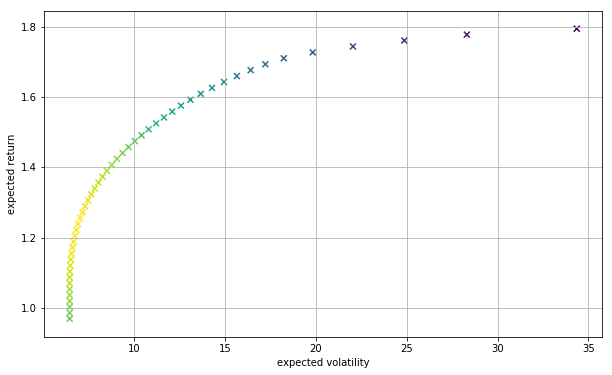

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(tvols, trets, c=trets/tvols, marker='x')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')

ハイリターンを狙う場合は右上のリスク・リターンのプロットを実現する最適投資比率になるように資産配分し，ローリスクを狙う場合には左下のプロットを実現する最適投資比率になるように資産配分します．